In [4]:
# Cell 1: Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os

# Ensure output directories exist
os.makedirs('C:/Users/Skyline/Intelligent-Complaint-Analysis-for-Financial-Services/data', exist_ok=True)

In [6]:
# Cell 2: Load the full CFPB complaint dataset in chunks
data_path = 'C:/Users/Skyline/Intelligent-Complaint-Analysis-for-Financial-Services/data/complaints.csv'
chunk_size = 100000  # Adjust based on your RAM (e.g., 100K rows per chunk)
chunks = pd.read_csv(data_path, low_memory=False, chunksize=chunk_size)

# Initialize variables for EDA
total_rows = 0
product_counts = {}
narrative_counts = {'with_narrative': 0, 'without_narrative': 0}
word_counts = []

# Process chunks for basic EDA
for chunk in chunks:
    total_rows += len(chunk)
    # Product distribution
    product_dist = chunk['Product'].value_counts()
    for product, count in product_dist.items():
        product_counts[product] = product_counts.get(product, 0) + count
    # Narrative presence
    narrative_counts['with_narrative'] += chunk['Consumer complaint narrative'].notna().sum()
    narrative_counts['without_narrative'] += chunk['Consumer complaint narrative'].isna().sum()
    # Word count (only for non-empty narratives)
    chunk['narrative_word_count'] = chunk['Consumer complaint narrative'].apply(
        lambda x: len(re.findall(r'\w+', str(x))) if pd.notna(x) else 0
    )
    word_counts.extend(chunk['narrative_word_count'].tolist())

# Print basic EDA
print(f"Total rows: {total_rows}")
print("Columns:", chunk.columns.tolist())  # From last chunk
print("Product distribution:\n", pd.Series(product_counts))
print(f"Complaints with narratives: {narrative_counts['with_narrative']}")
print(f"Complaints without narratives: {narrative_counts['without_narrative']}")
print("Word count stats:\n", pd.Series(word_counts).describe())

Total rows: 9609797
Columns: ['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue', 'Consumer complaint narrative', 'Company public response', 'Company', 'State', 'ZIP code', 'Tags', 'Consumer consent provided?', 'Submitted via', 'Date sent to company', 'Company response to consumer', 'Timely response?', 'Consumer disputed?', 'Complaint ID', 'narrative_word_count']
Product distribution:
 Credit reporting or other personal consumer reports                             4834855
Debt collection                                                                  799197
Credit card                                                                      226686
Checking or savings account                                                      291178
Money transfer, virtual currency, or money service                               145066
Mortgage                                                                         422254
Vehicle loan or lease                                                 

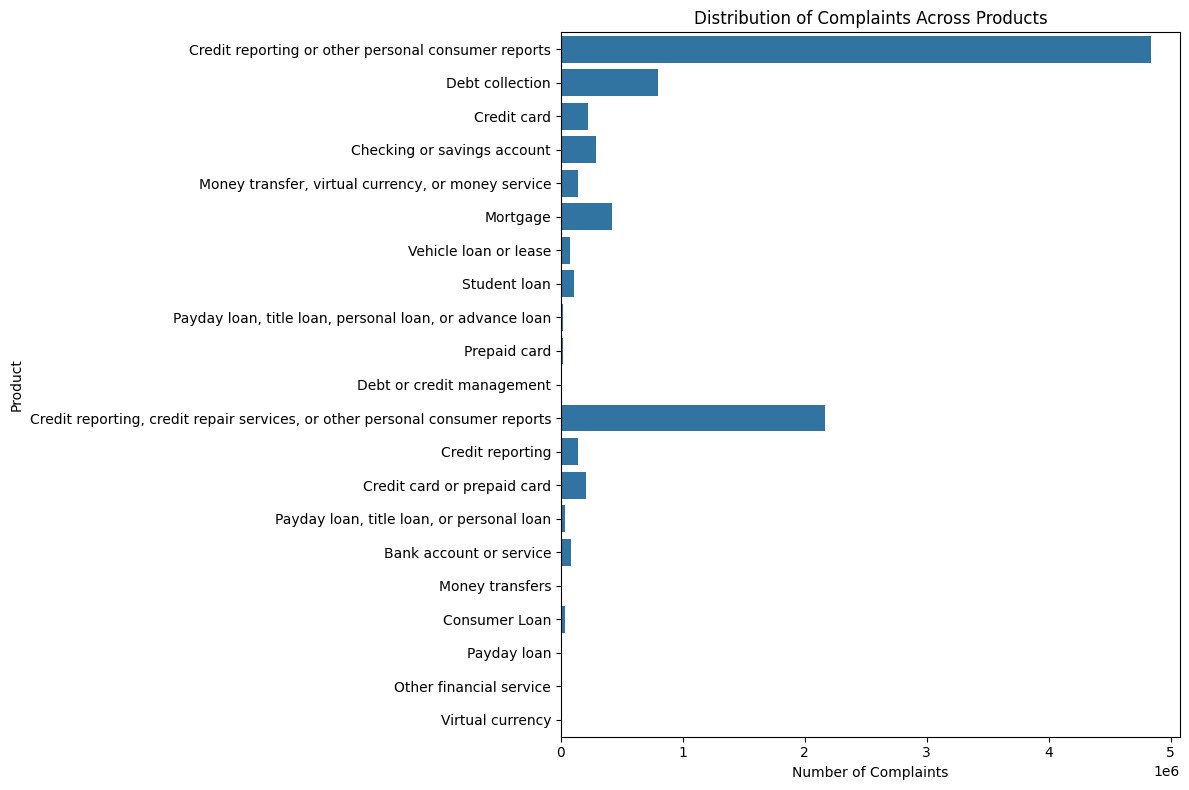

In [7]:
# Cell 3: Visualize product distribution
plt.figure(figsize=(12, 8))
sns.barplot(y=list(product_counts.keys()), x=list(product_counts.values()), orient='h')
plt.title('Distribution of Complaints Across Products')
plt.xlabel('Number of Complaints')
plt.ylabel('Product')
plt.tight_layout()
plt.savefig('C:/Users/Skyline/Intelligent-Complaint-Analysis-for-Financial-Services/data/product_distribution.png')
plt.show()

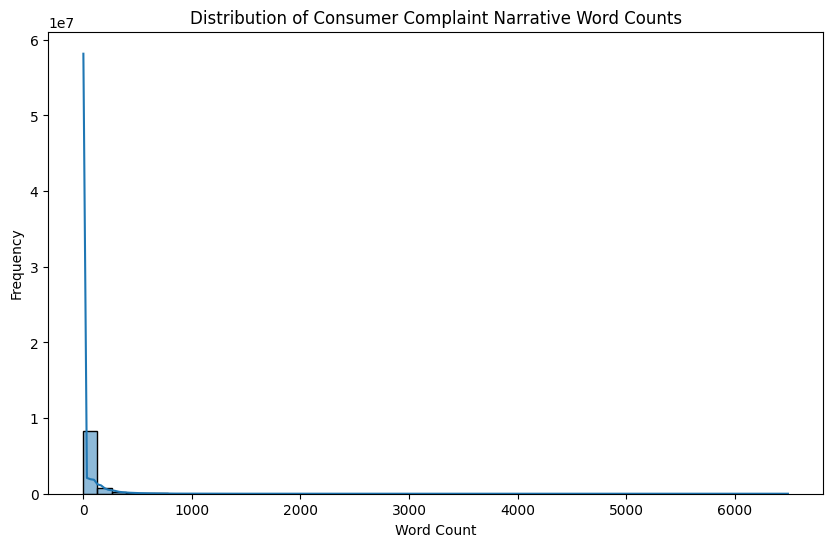

Very short narratives (<10 words): 6649560
Very long narratives (>500 words): 157595


In [8]:
# Cell 4: Visualize word count distribution
plt.figure(figsize=(10, 6))
sns.histplot(word_counts, bins=50, kde=True)
plt.title('Distribution of Consumer Complaint Narrative Word Counts')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.savefig('C:/Users/Skyline/Intelligent-Complaint-Analysis-for-Financial-Services/data/word_count_distribution.png')
plt.show()

# Analyze short/long narratives
short_narratives = sum(1 for wc in word_counts if wc < 10)
long_narratives = sum(1 for wc in word_counts if wc > 500)
print(f"Very short narratives (<10 words): {short_narratives}")
print(f"Very long narratives (>500 words): {long_narratives}")

In [ ]:
# Cell 5: Filter dataset and clean narratives
specified_products = [
    'Credit card', 'Credit card or prepaid card',  # Credit card, BNPL
    'Consumer Loan', 'Payday, title, or personal loan', 'Installment loan',  # Personal loan, BNPL
    'Checking or savings account',  # Savings account
    'Money transfer, virtual currency, or money service', 'Money transfers'  # Money transfers
]

def clean_narrative(text):
    if pd.isna(text):
        return ''
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s.,!?]', '', text)
    boilerplate_patterns = [
        r'i am writing to file a complaint',
        r'this is a complaint about',
        r'please investigate',
        r'xx/xx/xxxx', r'xxxx',
    ]
    for pattern in boilerplate_patterns:
        text = re.sub(pattern, '', text, flags=re.IGNORECASE)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Process chunks and save filtered data
filtered_path = 'C:/Users/Skyline/Intelligent-Complaint-Analysis-for-Financial-Services/data/filtered_complaints.csv'
first_chunk = True
total_filtered_rows = 0
for chunk in pd.read_csv(data_path, low_memory=False, chunksize=chunk_size):
    # Filter for specified products and non-empty narratives
    chunk_filtered = chunk[
        (chunk['Product'].isin(specified_products)) & (chunk['Consumer complaint narrative'].notna())
    ].copy()  # Avoid SettingWithCopyWarning
    if chunk_filtered.empty:
        print("Warning: No rows match specified products in this chunk. Check 'Product' values.")
        continue
    # Clean narratives
    chunk_filtered.loc[:, 'Consumer complaint narrative'] = chunk_filtered['Consumer complaint narrative'].apply(clean_narrative)
    # Save to CSV (append mode after first chunk)
    mode = 'w' if first_chunk else 'a'
    chunk_filtered.to_csv(filtered_path, index=False, mode=mode, header=first_chunk)
    total_filtered_rows += len(chunk_filtered)
    first_chunk = False
    print(f"Processed chunk, added {len(chunk_filtered)} rows, total filtered: {total_filtered_rows}")

# Load filtered dataset for verification
df_filtered = pd.read_csv(filtered_path, low_memory=False)
print("Filtered dataset shape:", df_filtered.shape)
print("Unique products in filtered data:", df_filtered['Product'].unique())

Processed chunk, added 396 rows, total filtered: 396
Processed chunk, added 472 rows, total filtered: 868
Processed chunk, added 505 rows, total filtered: 1373
Processed chunk, added 641 rows, total filtered: 2014
Processed chunk, added 999 rows, total filtered: 3013
Processed chunk, added 1509 rows, total filtered: 4522
Processed chunk, added 1807 rows, total filtered: 6329
Processed chunk, added 3333 rows, total filtered: 9662
Processed chunk, added 5886 rows, total filtered: 15548
Processed chunk, added 3723 rows, total filtered: 19271
Processed chunk, added 2471 rows, total filtered: 21742
Processed chunk, added 3000 rows, total filtered: 24742
Processed chunk, added 2714 rows, total filtered: 27456
Processed chunk, added 1790 rows, total filtered: 29246
Processed chunk, added 2487 rows, total filtered: 31733
Processed chunk, added 1878 rows, total filtered: 33611
Processed chunk, added 2388 rows, total filtered: 35999
Processed chunk, added 3580 rows, total filtered: 39579
Process